# Movie Recommendation Challenge

### Import Packages

In [3]:
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
import random
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import re
from scipy.sparse import csr_matrix
import scipy as sp

from sklearn.metrics import mean_squared_error
from math import sqrt
# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")
pd.set_option('display.max_columns', 37)
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display_html 
from IPython.core.display import HTML
from collections import defaultdict
import datetime
import re
#import squarify
import os
from sklearn.model_selection import train_test_split

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp

from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate





/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Loading Data

In [4]:
sample_submission = pd.read_csv('/kaggle/input/edsa-movie-recommender/sample_submission.csv')
movies = pd.read_csv('/kaggle/input/edsa-movie-recommender/movies.csv')
imdb_data = pd.read_csv('/kaggle/input/edsa-movie-recommender/imdb_data.csv')
genome_scores = pd.read_csv('/kaggle/input/edsa-movie-recommender/genome_scores.csv')
genome_tags = pd.read_csv('/kaggle/input/edsa-movie-recommender/genome_tags.csv')
train = pd.read_csv('/kaggle/input/edsa-movie-recommender/train.csv')
test = pd.read_csv('/kaggle/input/edsa-movie-recommender/test.csv')
tags = pd.read_csv('/kaggle/input/edsa-movie-recommender/tags.csv')
links = pd.read_csv('/kaggle/input/edsa-movie-recommender/links.csv')

In [5]:
# Merge train (users) and movies datasets on movieId column
train_movies_df = pd.merge(train, movies, how='left', on='movieId')

In [6]:

# Perform a further merge with imdb_data on movieId column
movies_metadata_df = pd.merge(train_movies_df, imdb_data, how='left', on='movieId')

### Data Description

### Data Processing 

#### Checking and removing null values from the datasets that we are planning to use

### Checking and removing duplicate values

In [7]:
movies_metadata_df['title_cast']=movies_metadata_df['title_cast'].str.split('|') #spliting the title cast into a list
movies_metadata_df['plot_keywords']=movies_metadata_df['plot_keywords'].str.split('|') #spliting the Key words into a list
movies_metadata_df['genres']=movies_metadata_df['genres'].str.split('|') #spliting the subgenres into a list
movies_metadata_df.head()

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]","[Elizabeth Berrington, Rudy Blomme, Olivier Bo...",Martin McDonagh,107.0,"$15,000,000","[dwarf, bruges, irish, hitman]"
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),[Comedy],"[Steve Martin, Diane Keaton, Martin Short, Kim...",Albert Hackett,106.0,"$30,000,000","[fatherhood, doberman, dog, mansion]"
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,"[Action, Comedy, Sci-Fi]","[Tommy Lee Jones, Will Smith, Rip Torn, Lara F...",Lowell Cunningham,88.0,"$140,000,000","[lingerie, michael jackson character, shorthai..."
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),"[Adventure, Comedy, Crime]","[Sandra Bullock, Regina King, Enrique Murciano...",Marc Lawrence,115.0,"$45,000,000","[female protagonist, cleave gag, good woman, fbi]"
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,"[Drama, Horror, Mystery, Thriller]","[Jeff Davis, Heather Langenkamp, Miko Hughes, ...",Wes Craven,112.0,"$8,000,000","[freddy krueger, elm street, famous director a..."


In [8]:
rating_counts = movies_metadata_df['rating'].value_counts()
print(rating_counts)

4.0    2652977
3.0    1959759
5.0    1445230
3.5    1270642
4.5     880516
2.0     656821
2.5     505578
1.0     311213
1.5     159731
0.5     157571
Name: rating, dtype: int64


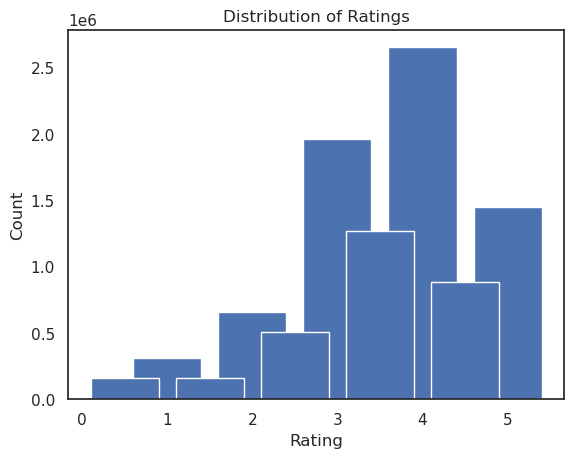

In [9]:
import matplotlib.pyplot as plt

plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

In [10]:
user_groups = movies_metadata_df.groupby('userId')
movies_rated_count = user_groups['movieId'].count()
print(movies_rated_count)



userId
1          28
2          72
3         251
4          89
5          35
         ... 
162537     36
162538     63
162539     18
162540     27
162541     94
Name: movieId, Length: 162541, dtype: int64


In [26]:
# Numeric features
numeric_features = ['rating', 'year','runtime']

# Normalize numeric features
scaler = StandardScaler()
movies_metadata_df[numeric_features] = scaler.fit_transform(movies_metadata_df[numeric_features])

In [12]:
# Create a Surprise Dataset object
reader = Reader(rating_scale=(0.5, 5.0))  # Specify the rating scale
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)


In [13]:
# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_metadata_df['plot_keywords'].apply(lambda x: ' '.join(x) if isinstance(x, list) else ''))


In [14]:
# Clustering using k-means
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

KMeans(n_clusters=10, random_state=42)

In [16]:
# Assigning cluster labels to movies
movies_metadata_df['cluster_label'] = kmeans.labels_

In [17]:
# Collaborative Filtering - SVD
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()
model = SVD()
model.fit(trainset)

In [19]:
# Create the testset in the required format
testset = list(zip(test['userId'], test['movieId'], [0.0] * len(test)))

In [20]:
# Predict ratings for the test dataset
predicted_ratings = model.test(testset)

# Extract the predicted ratings
predicted_ratings = [pred.est for pred in predicted_ratings]

In [21]:
# Generate submission file
submission_df = test.copy()
submission_df['Id'] = submission_df['userId'].astype(str) + '_' + submission_df['movieId'].astype(str)
submission_df['rating'] = predicted_ratings
submission_df = submission_df[['Id', 'rating']]
submission_df.to_csv('submission.csv', index=False)

In [22]:
# Evaluate the model
true_ratings = sample_submission['rating']
rmse = sqrt(mean_squared_error(true_ratings, predicted_ratings))
print("RMSE:", rmse)

RMSE: 2.637885873259705
